# Attention scoring

In [16]:
import math
import torch
from torch import nn
from d2l import torch as d2l

#### Masked sequence

In [17]:
# X: (5, 10)
# value: [1, 5, 3, 6, 2] -- matching the rows 

def sequence_mask(X, valid_len, value=0):
	"""Mask irrelevant entries in sequences."""

	maxlen = X.size(1)
	mask = torch.arange((maxlen), dtype=torch.float32, device=X.device)[None, :] < valid_len[:, None]
	#print(mask)

	X[~mask] = value # set the masked elements to value 
	return X

In [18]:
X = torch.arange(12).reshape(3, 4) + 1
y = torch.tensor([1, 3, 2])
z = sequence_mask(X, y)
print(z)

tensor([[ 1,  0,  0,  0],
        [ 5,  6,  7,  0],
        [ 9, 10,  0,  0]])


In [19]:
X = torch.arange(12).reshape(3, 4) + 1
y = torch.tensor([1, 3, 2])
z = sequence_mask(X, y)
print(z)

tensor([[ 1,  0,  0,  0],
        [ 5,  6,  7,  0],
        [ 9, 10,  0,  0]])


#### Masked softmax operation

In [20]:
# X: (2, 3, 4) -- attention weights
# valid lens: specify how many elements to mask in each minibatch 
# valid lens (high dim): specify how to mask each minibatch 
def masked_softmax(X, valid_lens):
	"""Perform softmax operation by masking elements on the last axis"""

	if valid_lens == None:
		return nn.functional.softmax(X, dim=-1)
	else:
		shape = X.shape
		if valid_lens.dim() == 1:
			# 
			valid_lens = torch.repeat_interleave(valid_lens, shape[1])
		else:
			valid_lens = valid_lens.reshape(-1)
		X = d2l.sequence_mask(X.reshape(-1, shape[-1]), valid_lens, value=-1e6)

		return nn.functional.softmax(X.reshape(shape), dim=-1)

In [21]:
X = torch.rand(2, 3, 4)
y = torch.tensor([2, 1])
z = masked_softmax(X, y)
print(X)
print(y)
print(z)

tensor([[[ 9.0041e-01,  3.4040e-01, -1.0000e+06, -1.0000e+06],
         [ 8.5498e-01,  4.9189e-01, -1.0000e+06, -1.0000e+06],
         [ 5.5380e-01,  2.4724e-01, -1.0000e+06, -1.0000e+06]],

        [[ 3.8983e-01, -1.0000e+06, -1.0000e+06, -1.0000e+06],
         [ 3.1435e-01, -1.0000e+06, -1.0000e+06, -1.0000e+06],
         [ 2.0591e-01, -1.0000e+06, -1.0000e+06, -1.0000e+06]]])
tensor([2, 1])
tensor([[[0.6365, 0.3635, 0.0000, 0.0000],
         [0.5898, 0.4102, 0.0000, 0.0000],
         [0.5760, 0.4240, 0.0000, 0.0000]],

        [[1.0000, 0.0000, 0.0000, 0.0000],
         [1.0000, 0.0000, 0.0000, 0.0000],
         [1.0000, 0.0000, 0.0000, 0.0000]]])


In [23]:
masked_softmax(torch.rand(2, 2, 4), torch.tensor([[1, 3], [2, 4]]))

tensor([[[1.0000, 0.0000, 0.0000, 0.0000],
         [0.3355, 0.4162, 0.2483, 0.0000]],

        [[0.4130, 0.5870, 0.0000, 0.0000],
         [0.2457, 0.2443, 0.3391, 0.1709]]])

#### Scaled dot-product attention

$$ A=softmax(\frac{QK^T}{\sqrt{d}})V$$

The scaled parameter $ \sqrt{d}$ is the dimension of key. This is choosen to produce correlation, but not too small so that the gradient works well.

In [25]:
class DotProductAttention(nn.Module):
	""""Scaled dot product attention with dropout"""

	def __init__(self, dropout, **kwargs):
		super(DotProductAttention, self).__init__(**kwargs)
		self.dropout = nn.Dropout(dropout)

		# query: (batch_size, no. of queries, 'd')
		# key: (batch_size, no. of key-value pairs, 'd')
		# value: (batch_size, no. of key-value pairs, d_value)
		# valid_lens: (batch_size, ) or (batch_size, no. of queries)
	
	def forward(self, queries, keys, values, valid_lens=None):
		d = queries.shape[-1]

		scores = torch.bmm(queries, keys.transpose(1, 2)) / math.sqrt(d)
		self.attention_weights = masked_softmax(scores, valid_lens)
		return torch.bmm(self.dropout(self.attention_weights), values)

In [27]:
queries = torch.normal(0, 1, (2, 1, 2))
keys = torch.ones((2, 10, 2))
values = torch.arange(40, dtype=torch.float32).reshape(1, 10, 4).repeat(2, 1, 1)
valid_lens = torch.tensor([2, 6])

attention = DotProductAttention(dropout=0.5)
attention.eval()
attention(queries, keys, values, valid_lens)

tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]])

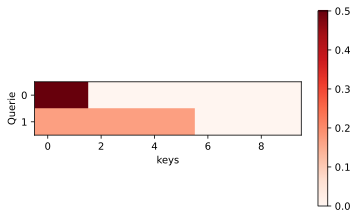

In [30]:
d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)), xlabel="keys", ylabel="Querie", figsize=(6, 6))